# Data Purpose and Exploration
The data is the carbon emissions from the electrical power industry from 1973 to 2016 and was provided by MIT: Professional Education Program. Data exploration will focus around natural gas with some of the questions in mind:
- What is the general trend of natural gas from 1973 to 2016?
- How does it compare to other power sectors, more specifically, how does it compare to the worst emitter?

## Importing libraries and data
___

In [1]:
# Import basic libraries
import pandas as pd
import warnings
import itertools
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline  

In [2]:
# to ignore warnings
import warnings
import itertools

warnings.filterwarnings("ignore")

In [3]:
df = pd.read_excel("MER_T12_06.xlsx")

## Setting up dataframe index and changing appropriate d-types of features
___

In [4]:
# Checking Data Types for each column
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5094 entries, 0 to 5093
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   MSN          5094 non-null   object
 1   YYYYMM       5094 non-null   int64 
 2   Value        5094 non-null   object
 3   Description  5094 non-null   object
dtypes: int64(1), object(3)
memory usage: 159.3+ KB


### Observations:
- The data type for date is "float", this will need to be converted to a date-time and then add as an index
- The "Value" column is an "object" this will  need to be converted to a numerical dtype
- The output shows no missing values; however, depending on how missing values are handled i.g. rather than an empty space, the inputter will put "no value", "missing value", etc., there could be missing values.


In [5]:
# Change "YYYYMM" to "Date"
# conversion of "Date" columnn into standard datetime format
# reformat "Date" from YYYYMM to YYYY-MM for ease of interpretation
# We are using errors=’coerce’. It will replace all non-numeric values with NaN.
# Remove all "NaT" values from Date

df = df.rename(columns={"YYYYMM": "Date"})
df["Date"] = pd.to_datetime(df["Date"], format="%Y%m", errors="coerce")
df.dropna(inplace=True)

In [6]:
# Set 'Date' as index and create an index column
df = df.reset_index().set_index("Date").to_period("M")

In [7]:
# Change "Value" to a numerical column and replace missing values with "NaN"
df["Value"] = pd.to_numeric(df["Value"], errors="coerce")

## "Description" feature simplifying
___
The unique categories in the "Description" feature all end in "Electric Power Sector CO2 Emissions", which is not needed since we already understand the purpose of the data. So, I'll create a library to remap the Description names.

In [8]:
# find the unique variables titles in "Description"
df["Description"].unique()

array(['Coal Electric Power Sector CO2 Emissions',
       'Natural Gas Electric Power Sector CO2 Emissions',
       'Distillate Fuel, Including Kerosene-Type Jet Fuel, Oil Electric Power Sector CO2 Emissions',
       'Petroleum Coke Electric Power Sector CO2 Emissions',
       'Residual Fuel Oil Electric Power Sector CO2 Emissions',
       'Petroleum Electric Power Sector CO2 Emissions',
       'Geothermal Energy Electric Power Sector CO2 Emissions',
       'Non-Biomass Waste Electric Power Sector CO2 Emissions',
       'Total Energy Electric Power Sector CO2 Emissions'], dtype=object)

In [9]:
# Rename the unique variables to a shortened version
mapping = {
    "Coal Electric Power Sector CO2 Emissions": "Coal",
    "Natural Gas Electric Power Sector CO2 Emissions": "Natural Gas",
    "Distillate Fuel, Including Kerosene-Type Jet Fuel, Oil Electric Power Sector CO2 Emissions": "Distillate Fuel",
    "Petroleum Coke Electric Power Sector CO2 Emissions": "Petroleum Coke",
    "Residual Fuel Oil Electric Power Sector CO2 Emissions": "Residual Fuel Oil",
    "Petroleum Electric Power Sector CO2 Emissions": "Petroleum",
    "Geothermal Energy Electric Power Sector CO2 Emissions": "Geothermal",
    "Non-Biomass Waste Electric Power Sector CO2 Emissions": "Non-Biomass Waste",
    "Total Energy Electric Power Sector CO2 Emissions": "Total Energy",
}

df["Description"] = df["Description"].map(mapping)

Let's next create feature columns from the categories in "Desciption". Each row will be indexed by date. This will make it easier to create graphs for comparing different power sectors

In [10]:
# Turn categorical variables in "Description" into separate rows
df = pd.pivot_table(df, index='Date', columns='Description', values='Value')

In [11]:
# Create columns for year and month
df["Year"] = df.index.year
df["Month"] = df.index.month

## Let's check quartiles and see if there are any outliers
___
Also, we can see what the actual count of missing values are from our dtype converstion above.

In [12]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Description,,,,,,,,
Coal,523.0,125.778954,31.903910,60.544,102.0150,129.054,151.5025,188.407
Distillate Fuel,523.0,0.774163,0.558520,0.258,0.4310,0.561,0.9310,4.038
Geothermal,331.0,0.031912,0.001861,0.025,0.0310,0.032,0.0330,0.035
Natural Gas,523.0,21.597245,10.585556,7.448,13.4275,18.459,27.0765,62.881
Non-Biomass Waste,331.0,0.850051,0.154092,0.335,0.8230,0.906,0.9455,1.083
Petroleum,523.0,9.527711,7.127673,1.191,4.3110,7.605,11.9200,36.935
Petroleum Coke,523.0,0.647772,0.585834,0.009,0.0825,0.575,1.0945,2.210
Residual Fuel Oil,523.0,8.105759,7.039863,0.334,2.7595,6.153,10.2810,32.884
Total Energy,523.0,157.462096,33.908393,91.834,129.7360,155.571,180.9200,247.995


### Observations:
- The top three contributors to CO2 Emissions over the time was Coal > Natural Gas > Petroleum
- Some power sources are constant over the time like: Distillate Fuel, Geothermal, Non-Biomass and Petroleum Coke
- There are missing values in Geothermal and Non-Biomass Waste

## Visualize the trend of CO2 emission from each energy source individually
___

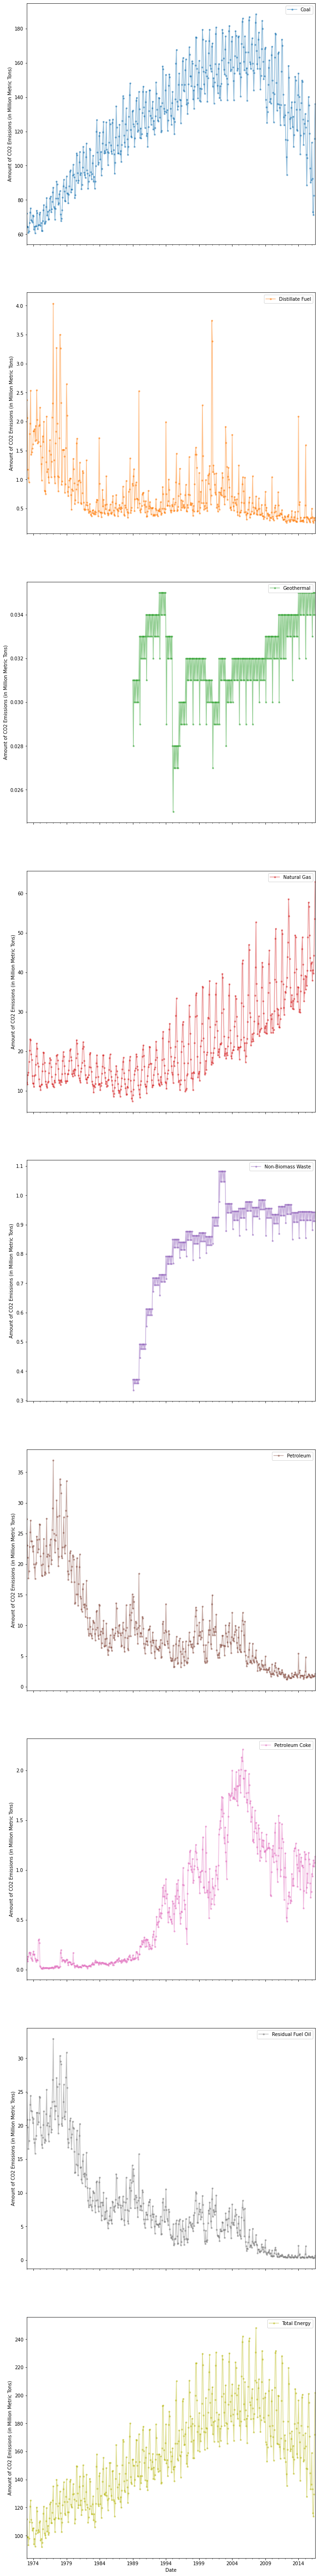

In [13]:
col = [
    "Coal",
    "Distillate Fuel",
    "Geothermal",
    "Natural Gas",
    "Non-Biomass Waste",
    "Petroleum",
    "Petroleum Coke",
    "Residual Fuel Oil",
    "Total Energy",
]

axes = df[col].plot(marker=".", alpha=0.5, linestyle="-", figsize=(11, 100), subplots=True,)
for ax in axes:
    ax.set_ylabel("Amount of CO2 Emissions (in Million Metric Tons)")
    ax.set_xlabel("Date")

### Observations
- Coal: linear trend from 1974 to 2004. The highest emissions occurred around 2006-2007. After 2009, the emissions dropped. This coincides with the Natural Gas usage trending up from 1999, which could mean plants were transitioning from coal to natural gas
- Distillate Fuel: Compared to Coal, the emissions are low. The trend to present is decreasing, which is apparent when comparing to earlier years like 1974 or 1979. The groupings are tighter as the years go on.
- Geothermal: The graph is showing no discernable trend, which could be related to the scale of the graph. The scale could be too large for this measurement and a log scale could be considered. I will not convert the scale as the focus of this project is on anthropogenic emission sources.
- Natural Gas: As stated above, there is an increasing trend of emissions starting in 1999.
- Non-Biomass Waste: The trend looks to have hit its maximum in 2009 at about 1 million metric tons of CO2
- Petroleum: There is a decreasing trend of emissions. Around 2011, the emissions are close to zero.
- Petroleum Coke: The highest peak of emissions was around 2005. After 2005, the emissions looked to have decreased. More data for future years should be observed to see if the trend downward has constant or has leveled-off
- Residual Fuel Oil: Since 1979, the trend has decreased, and in 2009, the value is around zero.
- Total Energy: The total energy hit a peak around 2009 and has decreased since then.

## Box Plot per year of CO2 Emissions for Natural Gas
___

[Text(0.5, 1.0, 'Natural Gas'),
 Text(0, 0.5, 'Amount of CO2 Emissions (in Million Metric Tons)')]

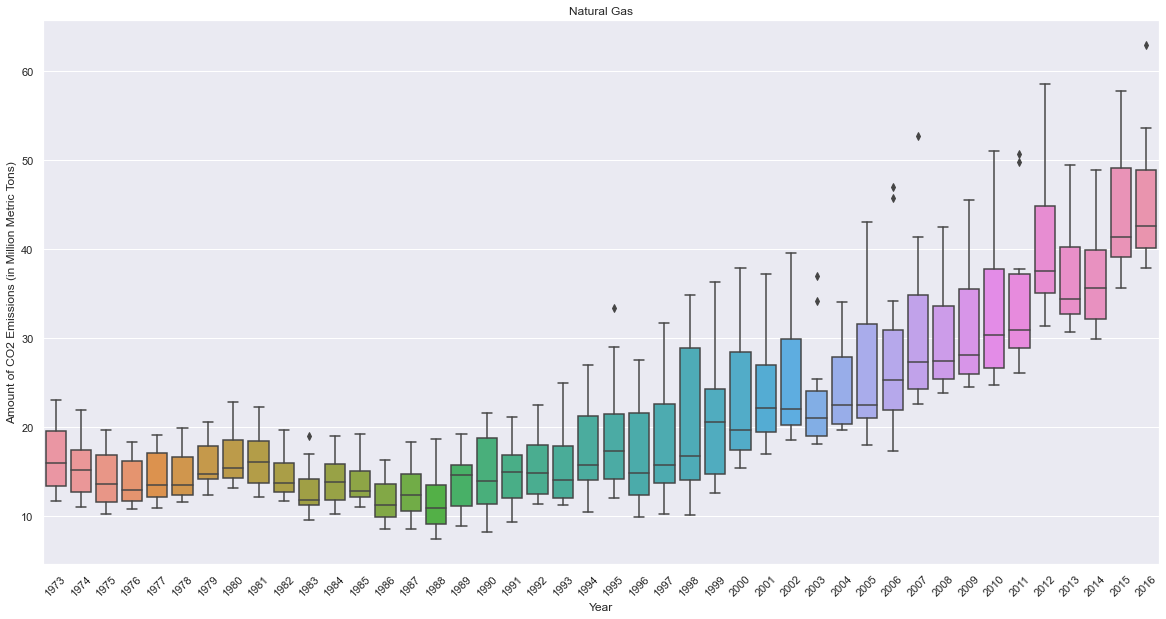

In [14]:
sns.set(rc={"figure.figsize": (20, 10)})
plt.xticks(rotation=45)
sns.boxplot(data=df, x="Year", y="Natural Gas").set(
    title="Natural Gas", ylabel="Amount of CO2 Emissions (in Million Metric Tons)"
)

### Observations

The purpose for graphing the box plot was to see the variability from year to year, especially for natural gas. Since the data contains the total emissions from large U.S. power plants, variables like how data is collected and number of plants in the total could cause variability from year to year. If large variations are seen, the data for training would be cut for lower test set variance in the forecasting analysis.

- For natural gas, no significant trend is observed on the variances, so all dates will be used for the model

## Bar chart of CO2 Emissions for the Top 3 Emissions Contributors
___

In [15]:
# Find the sum over each year for Bar Chart
df_bar = df.groupby("Year")[
    "Coal",
    "Distillate Fuel",
    "Geothermal",
    "Natural Gas",
    "Non-Biomass Waste",
    "Petroleum",
    "Petroleum Coke",
    "Residual Fuel Oil",
    "Total Energy",
].sum()

In [16]:
df_bar.head()

Description,Coal,Distillate Fuel,Geothermal,Natural Gas,Non-Biomass Waste,Petroleum,Petroleum Coke,Residual Fuel Oil,Total Energy
Year,,,,,,,,,
1973,811.791,19.914,0.0,198.856,0.0,275.702,1.558,254.232,1286.353
1974,800.131,22.526,0.0,186.718,0.0,263.795,1.922,239.348,1250.643
1975,823.740,16.507,0.0,171.892,0.0,248.185,0.217,231.458,1243.814
1976,911.347,17.738,0.0,167.222,0.0,272.619,0.209,254.672,1351.186
1977,962.143,20.670,0.0,174.226,0.0,305.760,0.300,284.787,1442.127


Text(0.5, 1.0, 'Bar Plot: CO2 Emissions Comparison Between Coal, Natural Gas, Petroleum')

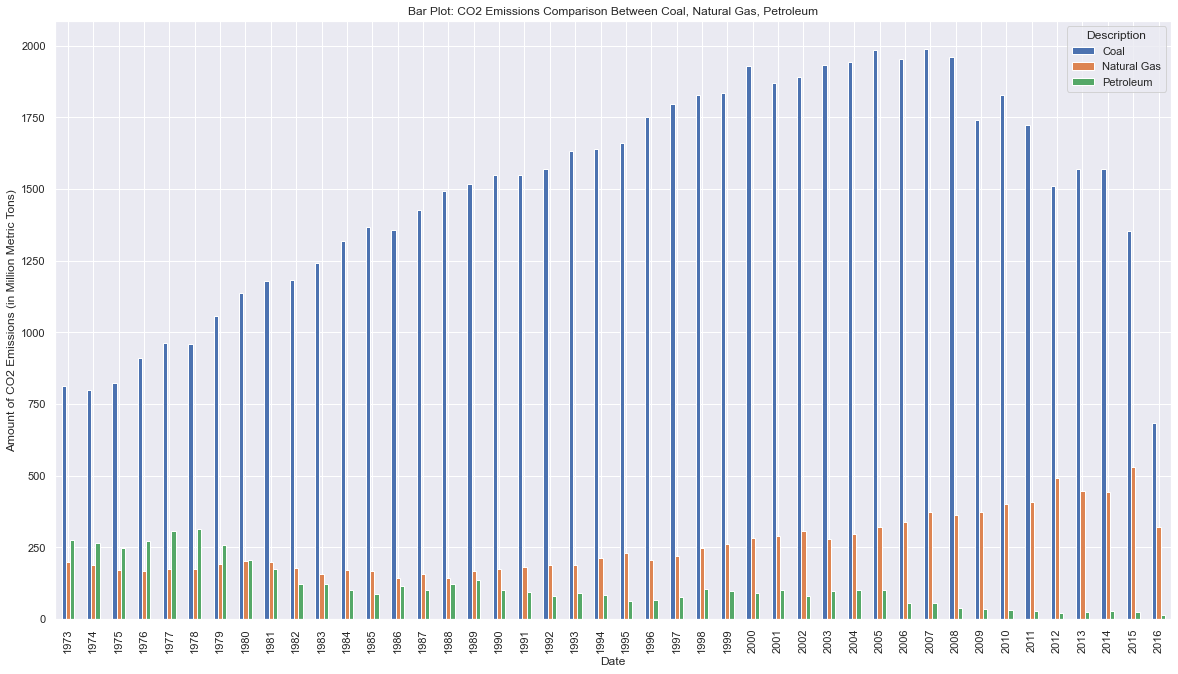

In [17]:
# Plot only the largest contributors to the total CO2 Emissions
df_bar.plot(y=[
    "Coal",
    "Natural Gas",
    "Petroleum",
], kind="bar", figsize=(20, 11))
plt.ylabel("Amount of CO2 Emissions (in Million Metric Tons)")
plt.xlabel('Date')
plt.title("Bar Plot: CO2 Emissions Comparison Between Coal, Natural Gas, Petroleum")

### Observations
- The emissions by Coal are much larger (~2-10) magnitudes higher than the second largest contributor of CO2 emissions, Natural Gas.
- As natural gas emissions increase, the coal emissions decrease. There could be some emissions dependencies between natural gas and coal, and an assumption like, "natural gas plants are replacing coal plants due to higher business benefits" could be made.

Let's visualize how the ratio of coal and natural gas changes with time.

In [18]:
# Create a new column which calculates the factor difference between Coal and Natural Gas
df_bar["Emission Magnitude"] = df_bar["Coal"]/df_bar["Natural Gas"]

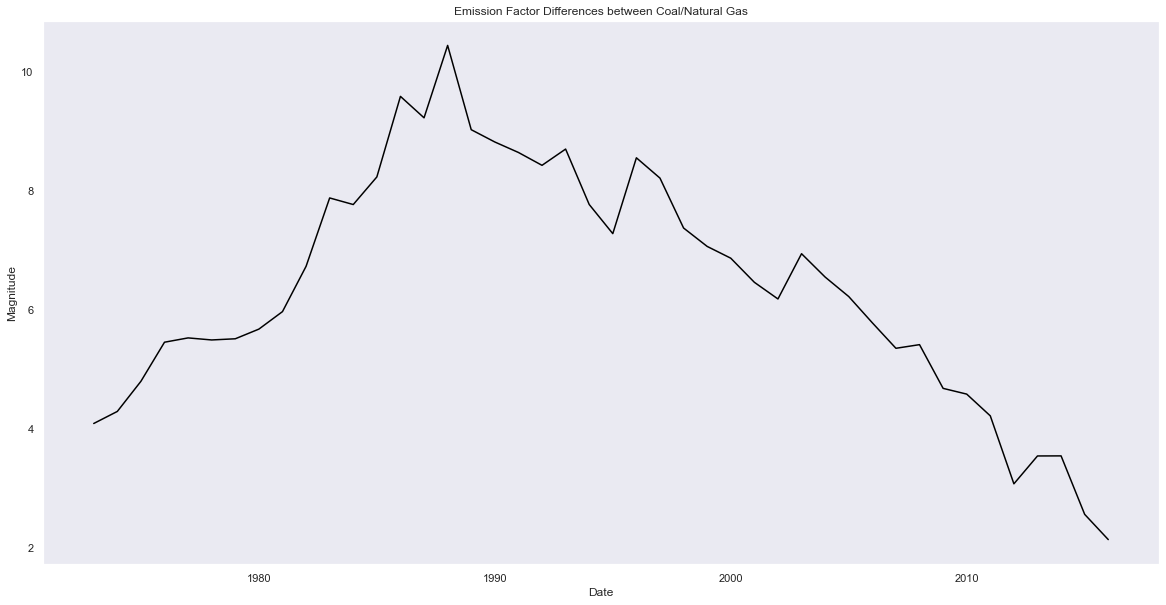

In [19]:
# Create line plot of the magnitude difference between Coal and Natural Gas
fig, ax = plt.subplots()
ax.plot(df_bar['Emission Magnitude'], color='black', label='Coal:Natural Gas')
ax.set_ylabel('Magnitude')
ax.set_xlabel('Date')
ax.set_title('Emission Factor Differences between Coal/Natural Gas')
plt.grid()

### Observations
- The largest magnitude occurred in ~1988 with about 10.4x difference between Coal and Natural Gas.
- The difference between the two is about 2:1 by 2016, which is occurring because Coal emissions are decreasing at the same time Natural Gas emissions are increasing.